In [44]:
import pdb, os, pickle,json 
import math 
import random
import pandas as pd
import numpy as np 
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp 
from matplotlib import pyplot as plt 
import seaborn as sns 
from sklearn.metrics import adjusted_rand_score 
import requests
import json
 
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 
%load_ext autoreload
%autoreload 2
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22
condL = ['blocked','interleaved','early','middle','late']
ns=100
unique_num = random.uniform(0, 1e4)
all_sims =  ["sim1", "sim2", "sim3", "sim4", "sim5", "sim6","sim7"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# run simulations 1 through 7 from the paper and save data (simulation 3 variant with results displayed in Figure S4 is called simulation 4 here, across-seed stickiness variability is simulation 5, across-seed sparsity variability is simulation 6, and simulation 3 with Bayes-optimal posterior predictive distribution is simulation 7). The purpose of this notebook is to run the simulations with new seeds other than the seeds that were saved for the sake of recreating the exact figures.

In [45]:
model_acc_df_list = []
model_states_df_list = []
# Opening JSON file
r = requests.get('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sim_to_args.json')
sim_to_args = r.json()
for sim_name in all_sims:
  print(sim_name)
  args = sim_to_args[sim_name]
  paramstr = get_param_str_from_args(args)
  print(args)
  # these two simulations have the concentration paramater value varied
  # across seeds 
  concentration_info = None
  stickiness_info = None
  sparsity_info = None
  if (sim_name == "sim3" or sim_name == "sim4" or sim_name == "sim7"):
    concentration_sd = 0.3
    concentration_lb = 0
    concentration_ub = np.inf
    concentration_mean = args["sch"]["concentration"]
    concentration_info = {
      'concentration_mean': concentration_mean,
      'concentration_sd': concentration_sd,
      'concentration_lb': concentration_lb,
      'concentration_ub': concentration_ub
    }
  
  elif sim_name == "sim5":
    stickiness_sd = 0.3
    stickiness_lb = 0
    stickiness_ub = 100
    stickiness_mean = args["sch"]["stickiness"]
    stickiness_info = {'stickiness_mean':stickiness_mean,
                        'stickiness_sd': stickiness_sd,
                        'stickiness_lb': stickiness_lb,
                        'stickiness_ub': stickiness_ub
                        }

  elif sim_name == "sim6":
    sparsity_sd = 0.05
    sparsity_lb = 0
    sparsity_ub = np.inf
    sparsity_mean = args["sch"]["sparsity"]
    sparsity_info = {'sparsity_mean':sparsity_mean,
                        'sparsity_sd': sparsity_sd,
                        'sparsity_lb': sparsity_lb,
                        'sparsity_ub': sparsity_ub
                        }

  if sim_name == "sim4":
    (exp_batch_data, concentrationValue_each_seed,stickinessValue_each_seed,sparsityValue_each_seed)  = run_batch_exp_curr_sim4(ns,args,condL,concentration_info = concentration_info, stickiness_info= stickiness_info, sparsity_info=sparsity_info)
  else:
    (exp_batch_data, concentrationValue_each_seed,stickinessValue_each_seed,sparsityValue_each_seed)  = run_batch_exp_curr(ns,args,condL,concentration_info = concentration_info, stickiness_info= stickiness_info, sparsity_info=sparsity_info)
  # unpack and save
  exp = np.stack([exp_batch_data[c][s]['exp'] for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  zt = np.stack([exp_batch_data[c][s]['zt'] for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  xth = np.stack([exp_batch_data[c][s]['xth'].argmax(-1) for c in range(5) for s in range(ns)]).reshape(5,ns,200,5)
  acc = unpack_acc(exp_batch_data,mean_over_tsteps=True)
  # for each of the condition types (blocked, interleaved, early, middle, late)
  for cix in range(5):
      # for each seed
      for six in range(ns):
        # get the concentration value if sim 3 or sim 4
        if (sim_name == "sim3" or sim_name == "sim4" or sim_name == "sim7"):
          # get the concentration value for this condition and seed 
          varied_parameter_this_seed = concentrationValue_each_seed[cix][six]  
        elif sim_name == "sim5":
          varied_parameter_this_seed = stickinessValue_each_seed[cix][six]  

        elif sim_name == "sim6":
          varied_parameter_this_seed = sparsityValue_each_seed[cix][six]  

        else:
          # otherwise just mark it -1000 (this avoids pandas issues later on)
          varied_parameter_this_seed = -1000
        # and trial number
        for trix in range(200):

          model_acc_df_list.append({
            'gs':sim_name,
            'varied_parameter':varied_parameter_this_seed,
            'cond':cix, # condition
            'seed':six, # seed
            'trial':trix, # trial
            'acc':acc[cix,six,trix] # get accuracy for this conditon, seed, trial
                                  # unpack_acc function averages over tstep in trial
          })
          for tstep in range(5):
            model_states_df_list.append({
            'gs':sim_name,
            'varied_parameter':varied_parameter_this_seed,
            'cond':cix,
            'seed':six,
            'trial':trix,
            'tstep':tstep,
            'exp':exp[cix,six,trix,tstep],
            'zt':zt[cix,six,trix,tstep],
            'xth':xth[cix,six,trix,tstep]
            })
model_acc_df = pd.DataFrame(model_acc_df_list)
model_states_df = pd.DataFrame(model_states_df_list)
# make a test column
model_acc_df.loc[:,'test'] = model_acc_df.trial >= 160

sim1
{'sem': {'skipt1': 0.0, 'ppd_allsch': 0}, 'sch': {'concentration': 4.775016084, 'stickiness': 96.79198472087737, 'sparsity': 0.050580176}, 'exp': {'condition': -1000, 'n_train': 160, 'n_test': 40}}
sim2
{'sem': {'skipt1': 1.0, 'ppd_allsch': 0}, 'sch': {'concentration': 1.7026910310943673, 'stickiness': 1.8476105399460376, 'sparsity': 0.2112472814674634}, 'exp': {'condition': -1000, 'n_train': 160, 'n_test': 40}}
sim3
{'sem': {'skipt1': 1.0, 'ppd_allsch': 0}, 'sch': {'concentration': 3.604484430987487, 'stickiness': 5.056799655, 'sparsity': 0.4358791197361261}, 'exp': {'condition': -1000, 'n_train': 160, 'n_test': 40}}
sim4
{'sem': {'skipt1': 0.0, 'ppd_allsch': 0}, 'sch': {'concentration': 4.055176291930948, 'stickiness': 5.714670380370007, 'sparsity': 0.3427017613731274}, 'exp': {'condition': -1000, 'n_train': 160, 'n_test': 40}}
sim5
{'sem': {'skipt1': 1.0, 'ppd_allsch': 0}, 'sch': {'concentration': 4.113339737291655, 'stickiness': 5.629858085774998, 'sparsity': 0.472781057850033

# plot results from the above runs of simulations 1 through 7

In [46]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','gold','gold','red'],
  'early': ['blue','green','gold','gold','red'],
  'inserted_early_rep': ['blue','green','gold','gold','red'],
  'inserted_middle': ['gold','blue','green','gold','red'],
  'middle': ['gold','blue','green','gold','red'],
  'inserted_middle_rep': ['gold','blue','green','gold','red'],
  'inserted_late': ['gold','gold','blue','green','red'],
  'late': ['gold','gold','blue','green','red'],
  'inserted_late_rep': ['gold','gold','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplot_model(gsname,condstr,cond_index,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  ax.set_title(gsname+" " + condL[cond_index])
  return ax
  
def lineplot_modelBI(gsname,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}' , cond_index = ix,ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(gsname):
  for ix in [2,3,4]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}', cond_index = ix, ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(gsname,condstr, ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('condition')
  ax.set_title(gsname)

def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond_int<2')

def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond_int>=2')


/var/folders/pf/tt62zb815q137j4hg0_k1hwr0000gn/T/ipykernel_31068/2271283780.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


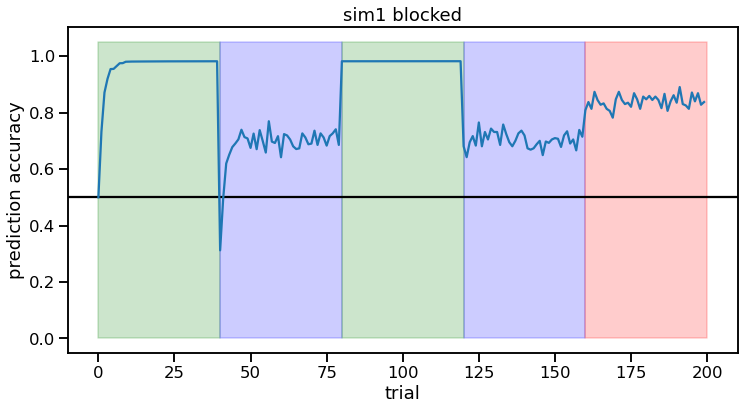

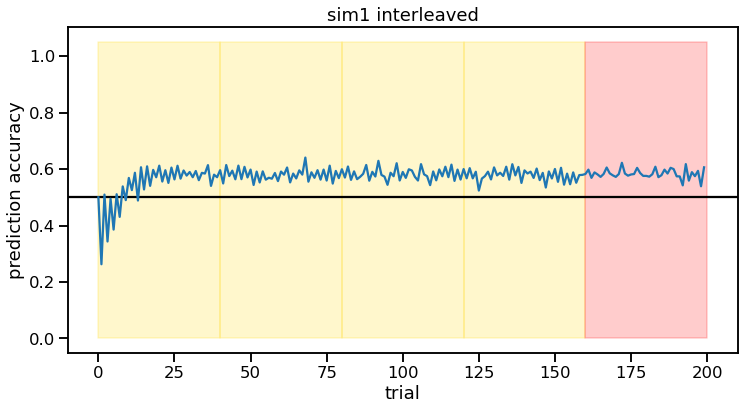

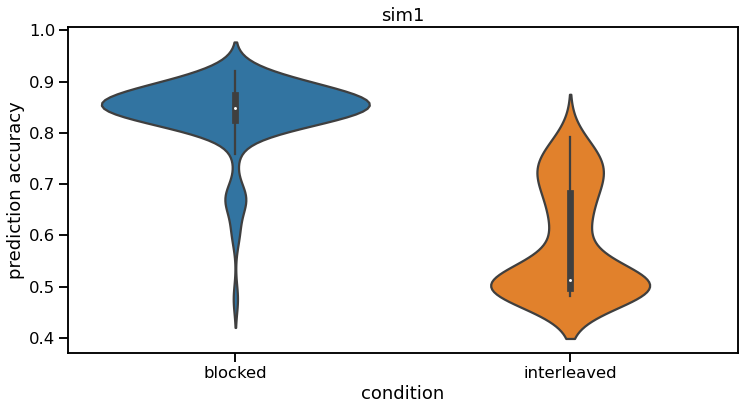

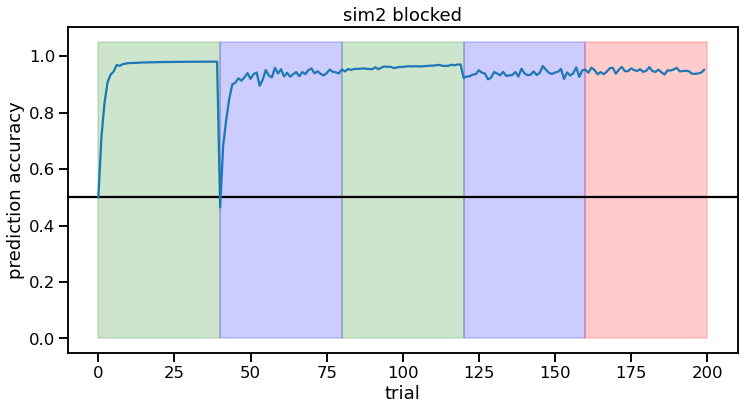

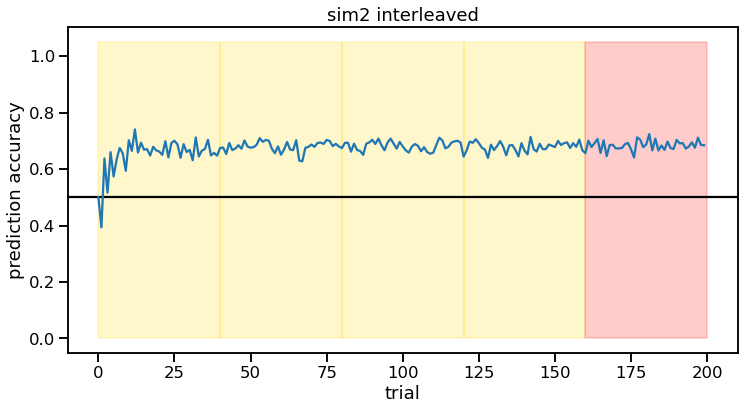

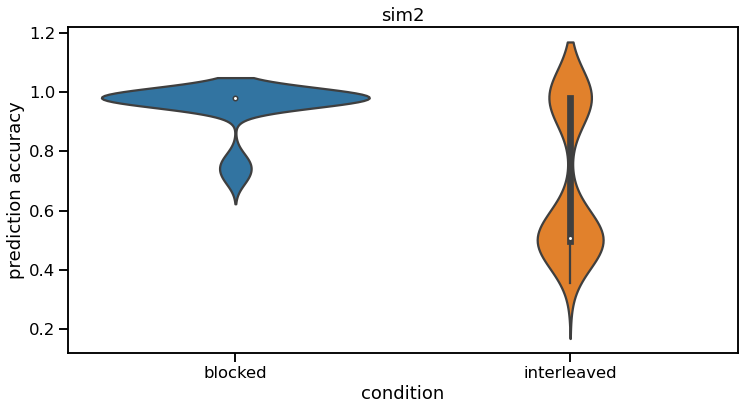

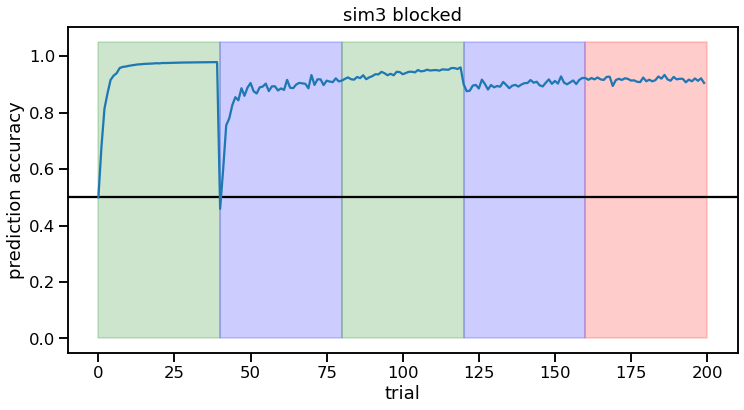

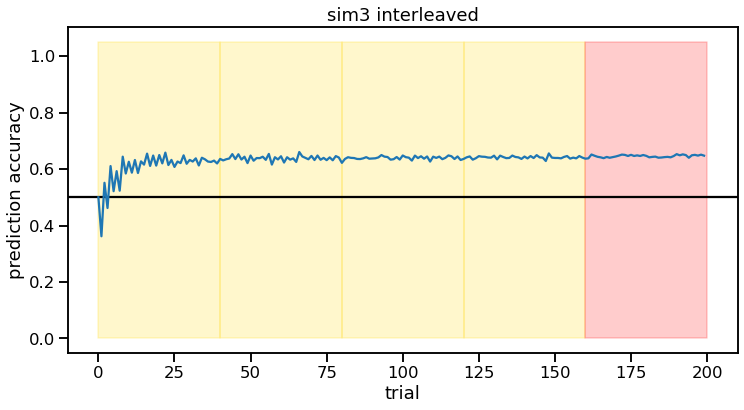

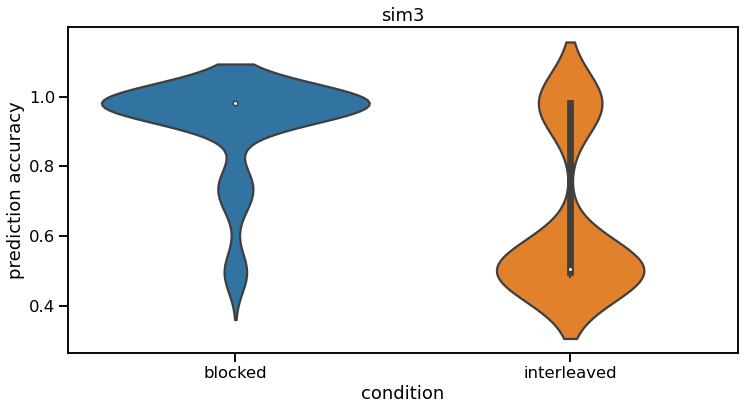

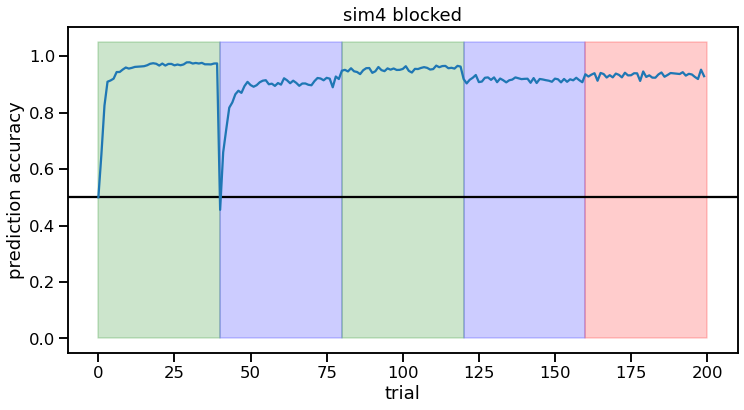

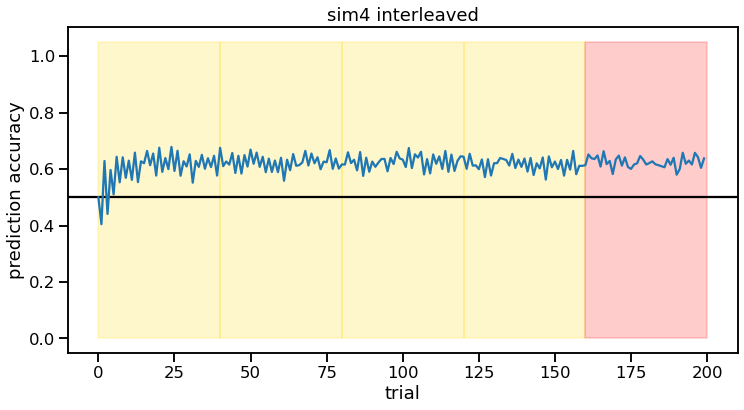

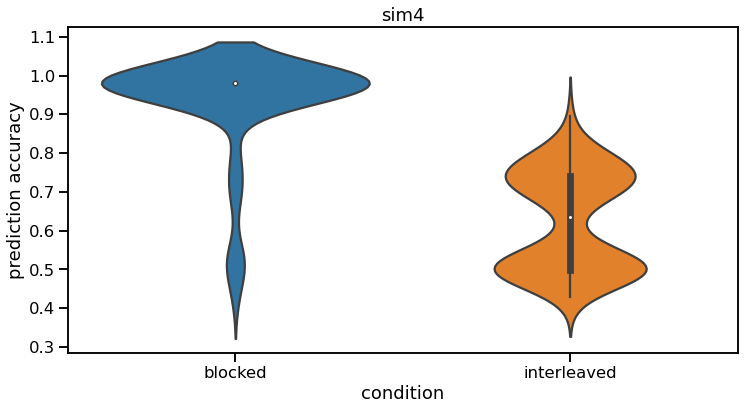

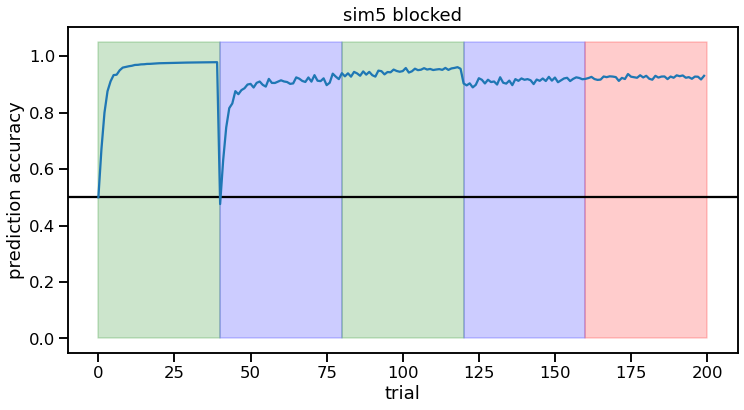

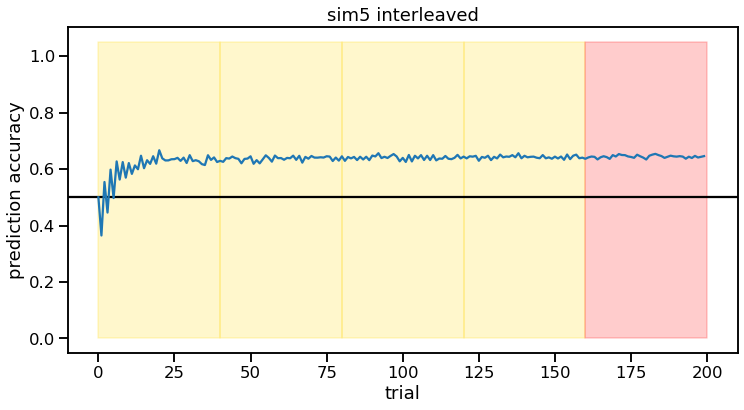

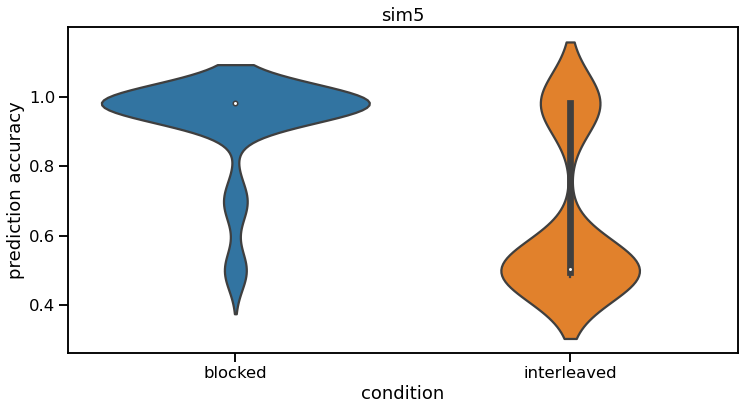

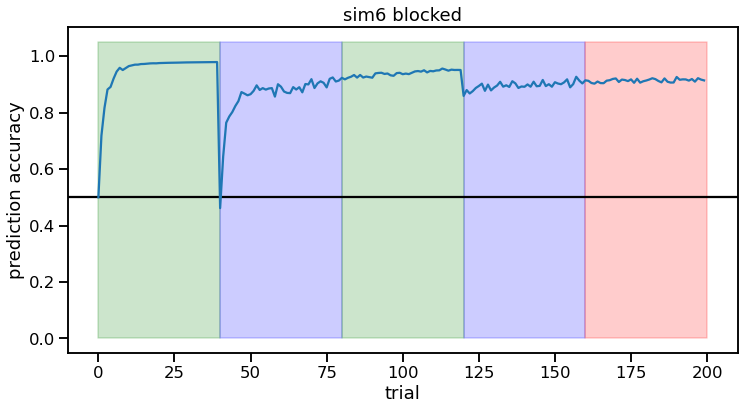

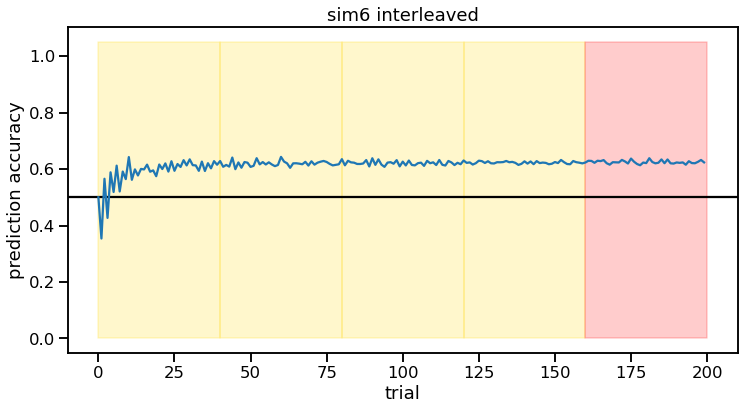

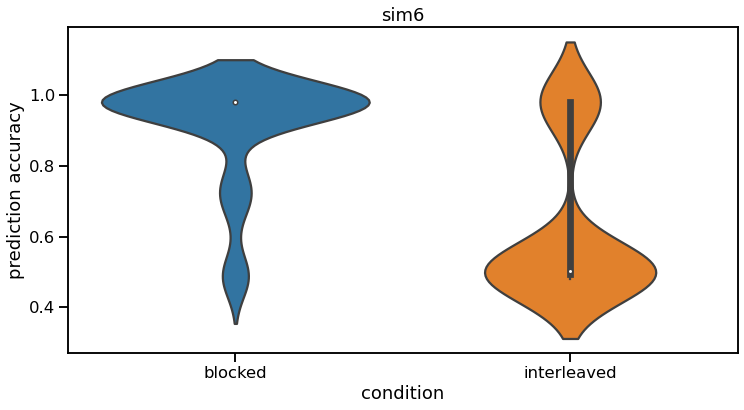

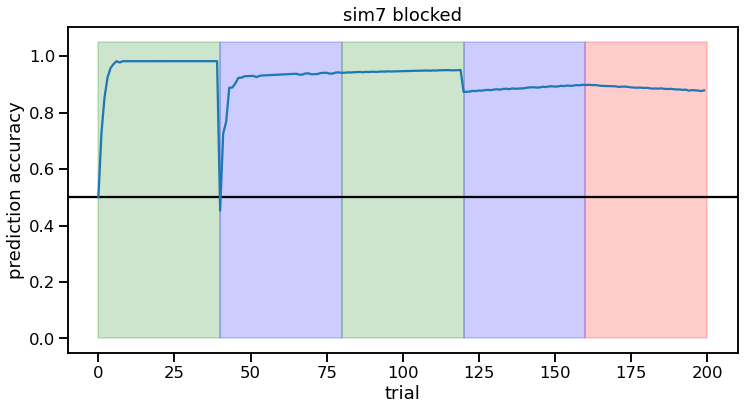

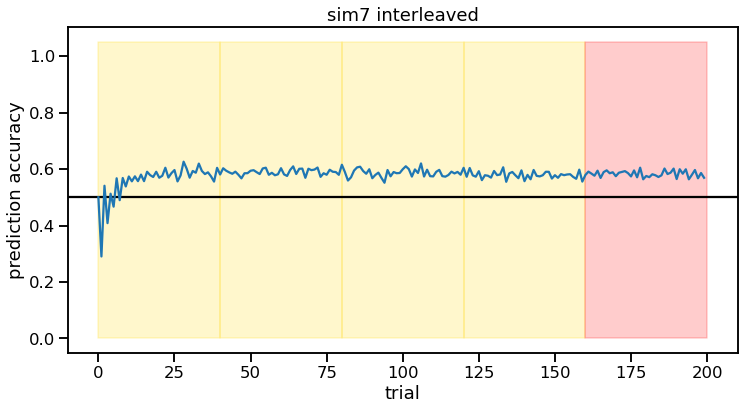

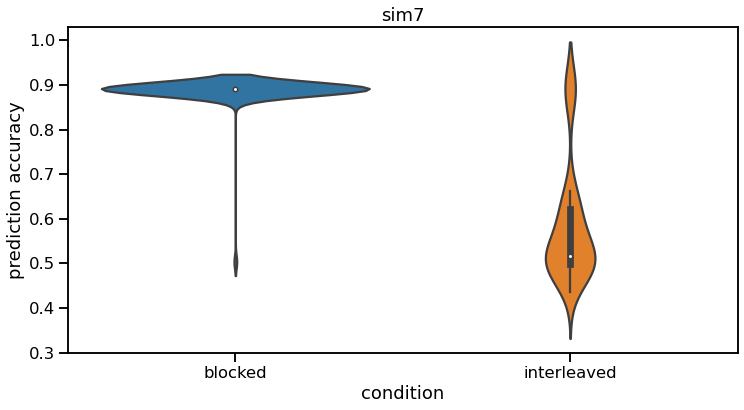

In [47]:
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])
for gsname in all_sims:
    lineplot_modelBI(gsname)
    beeswarm_modelBI(gsname)

/var/folders/pf/tt62zb815q137j4hg0_k1hwr0000gn/T/ipykernel_31068/2271283780.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,6))


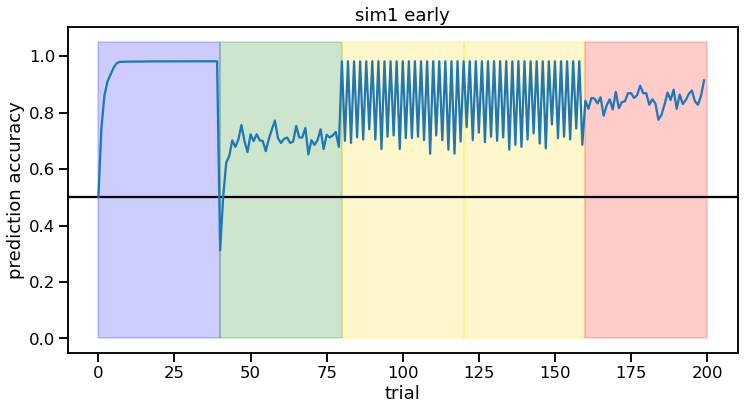

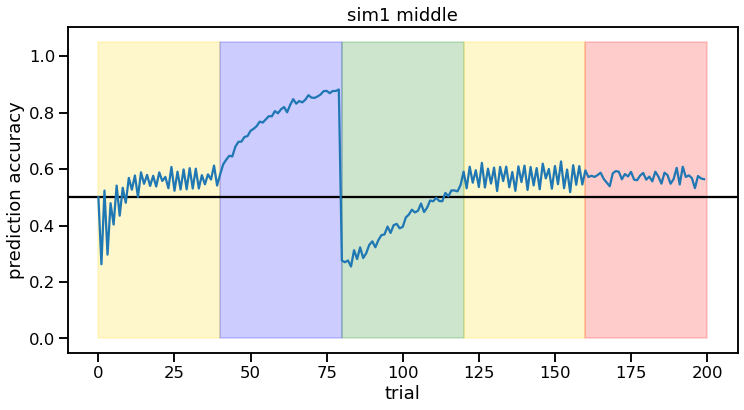

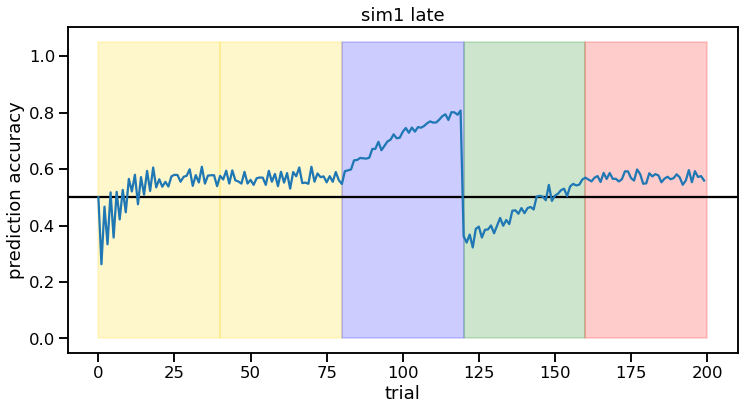

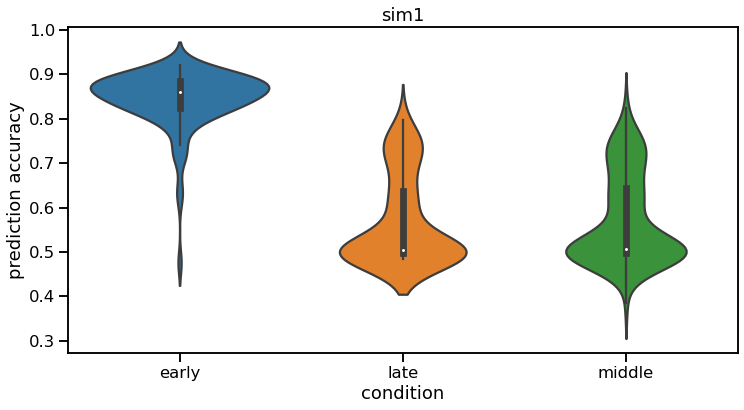

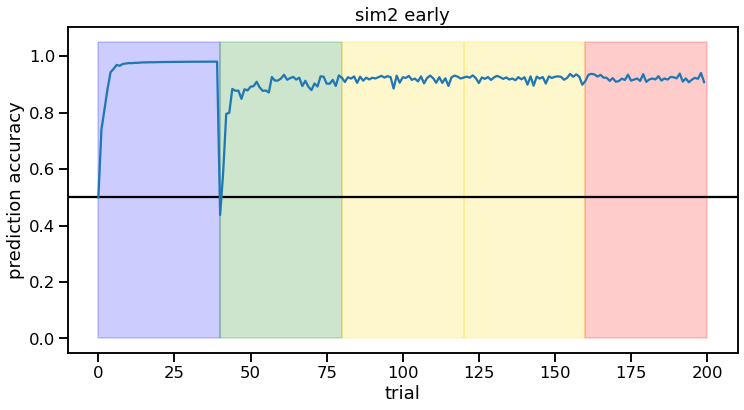

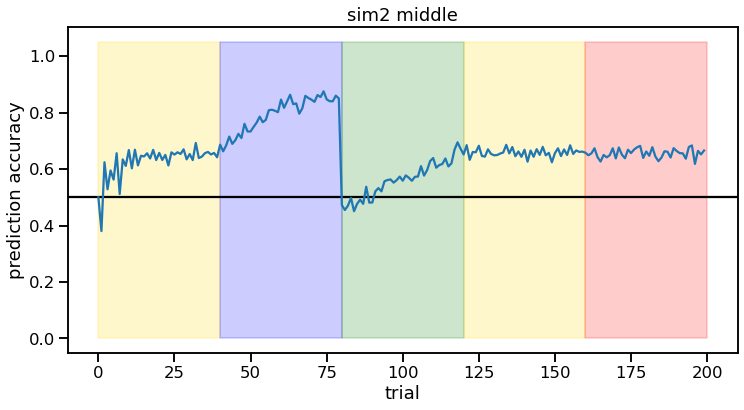

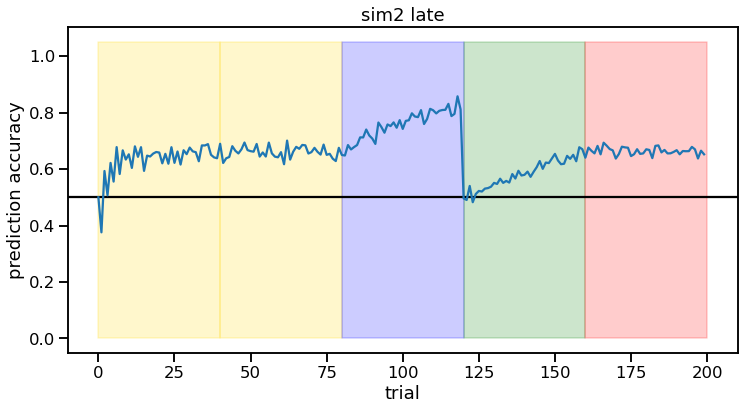

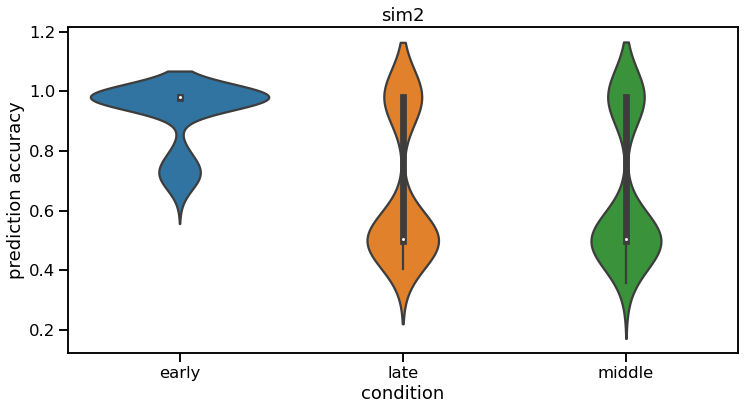

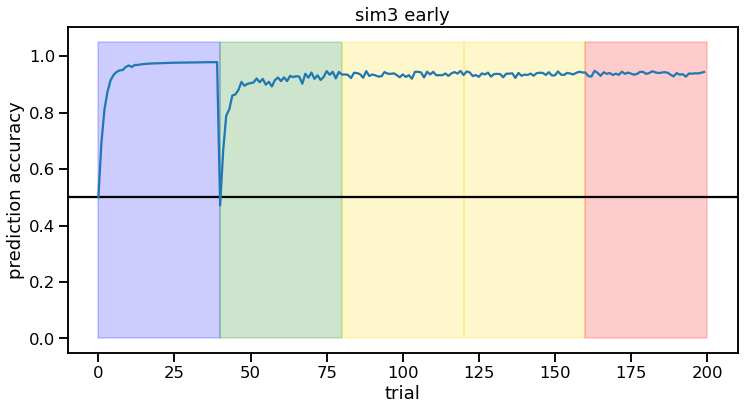

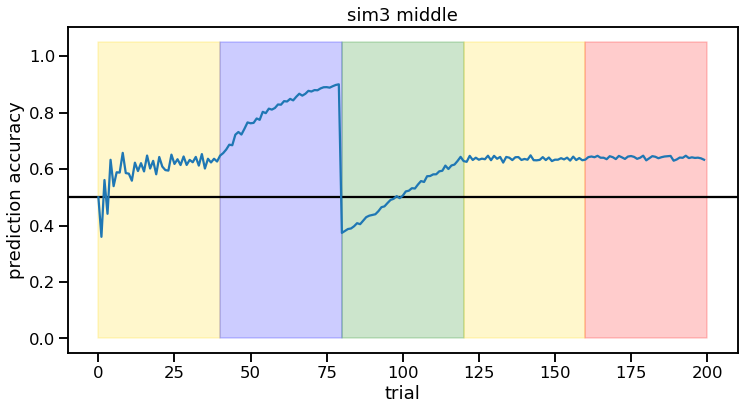

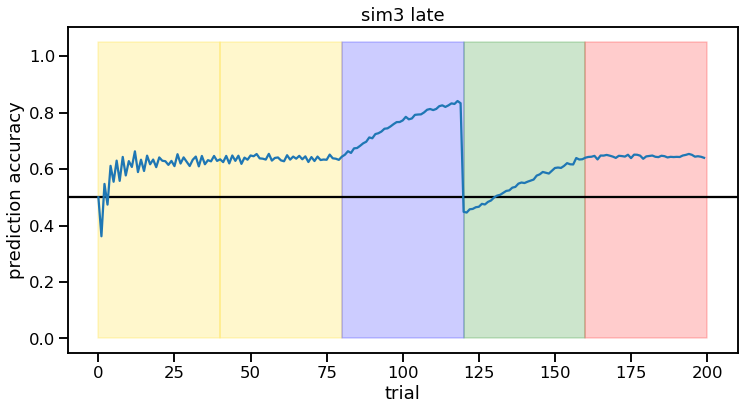

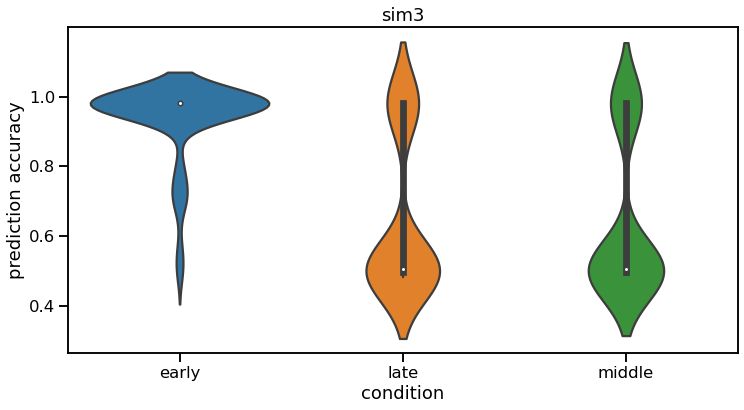

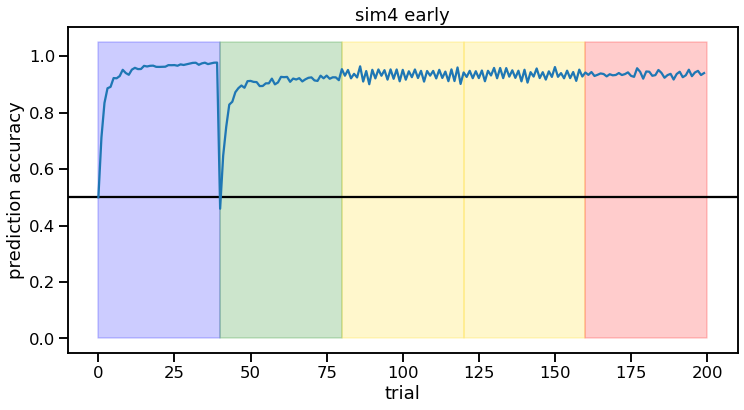

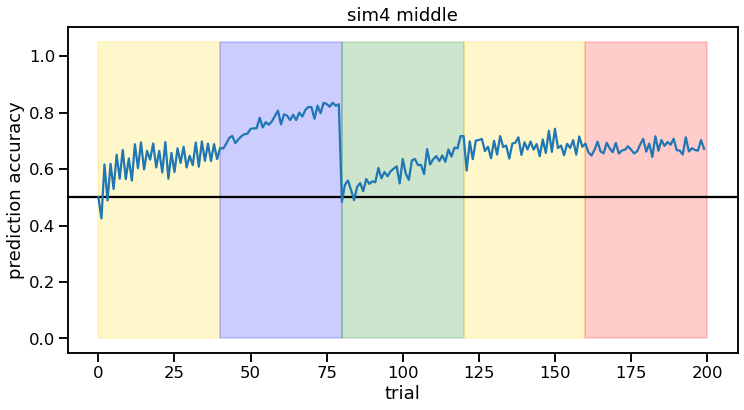

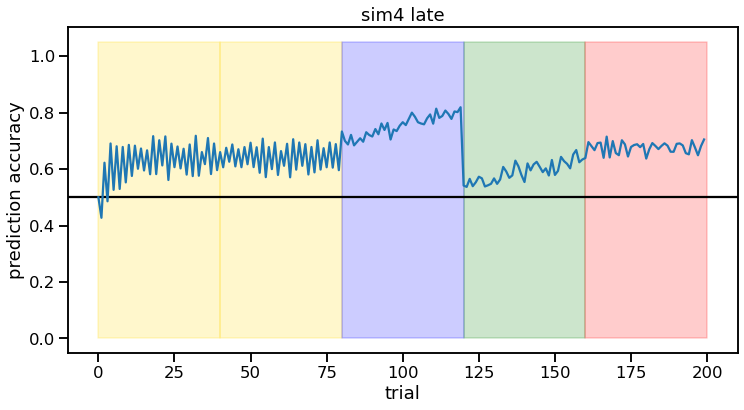

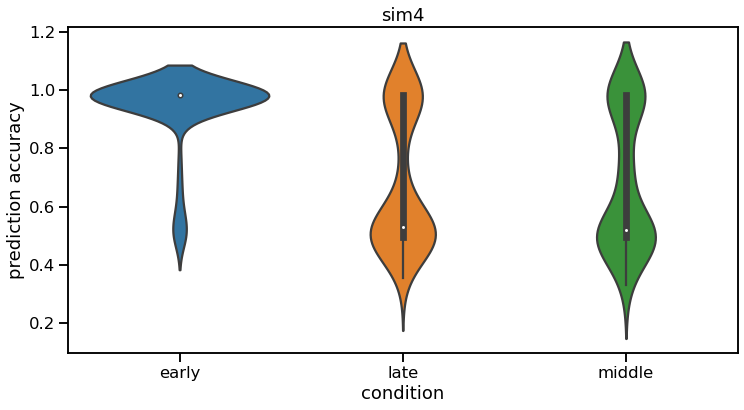

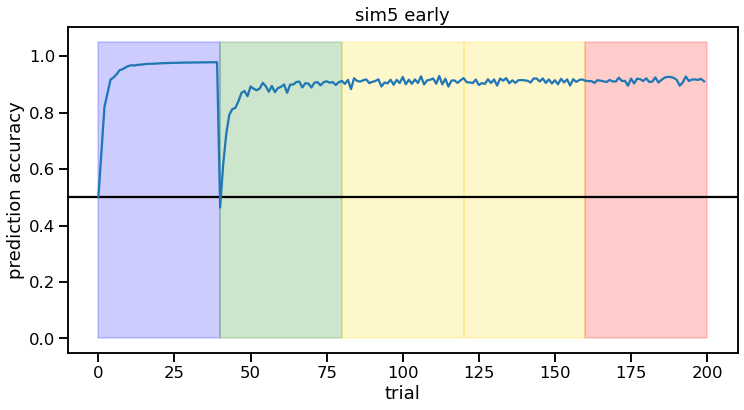

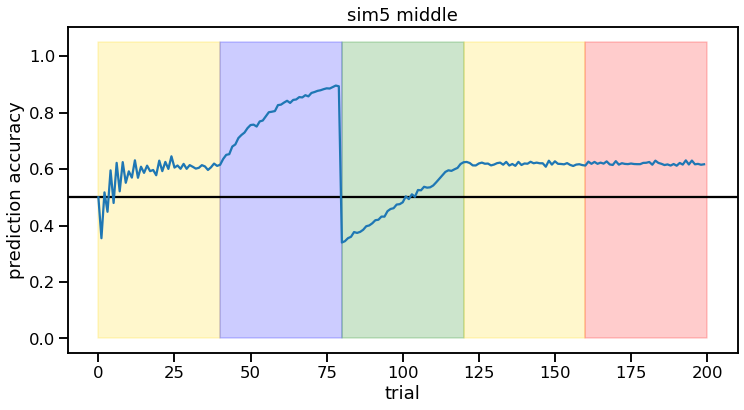

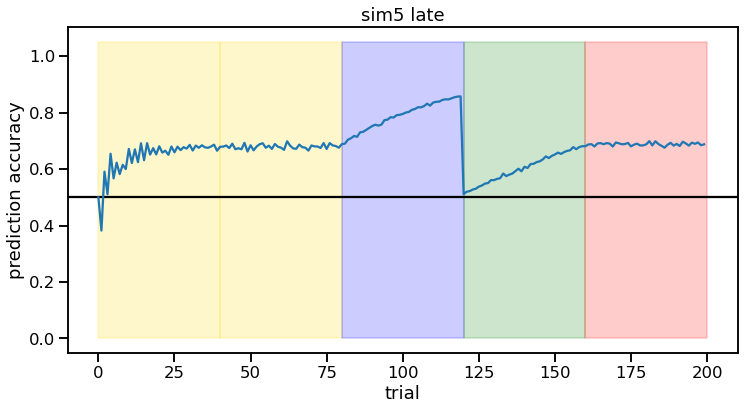

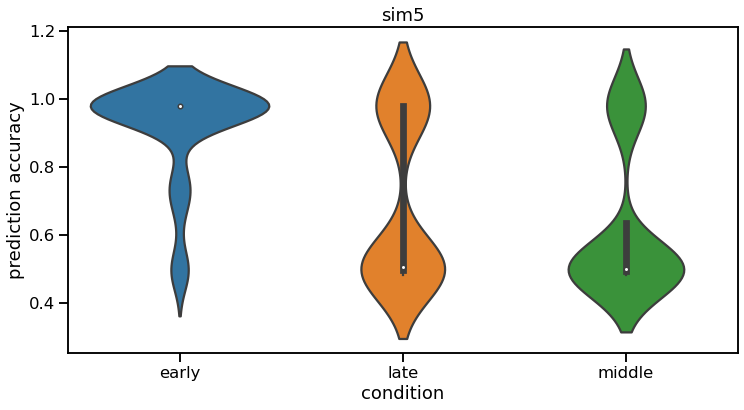

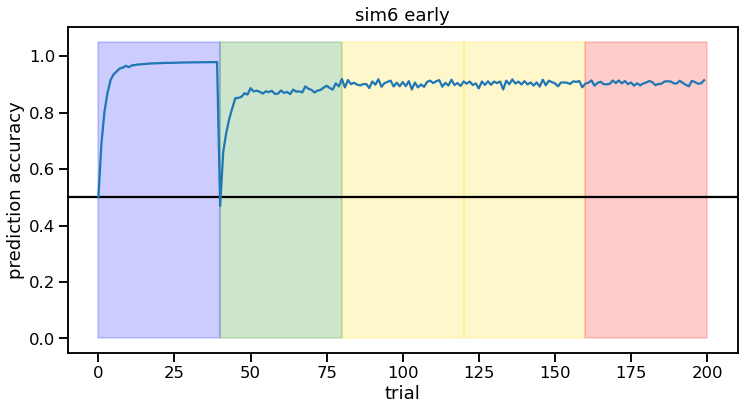

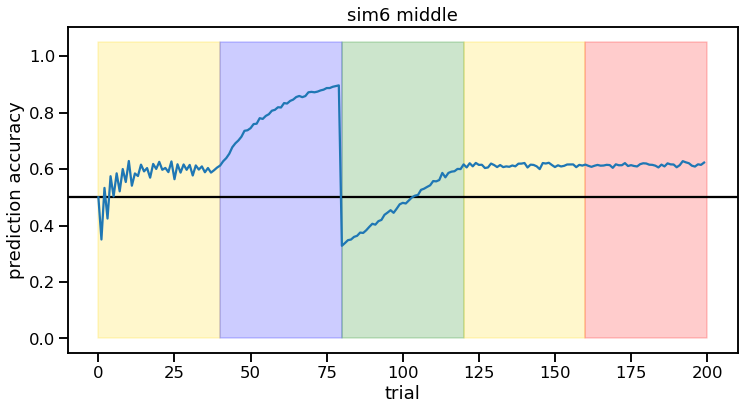

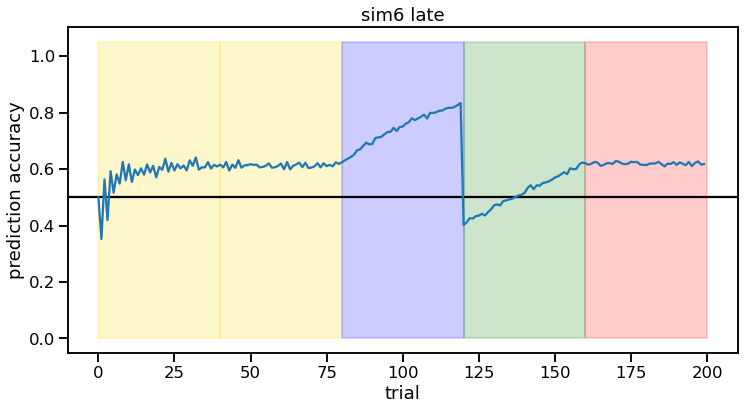

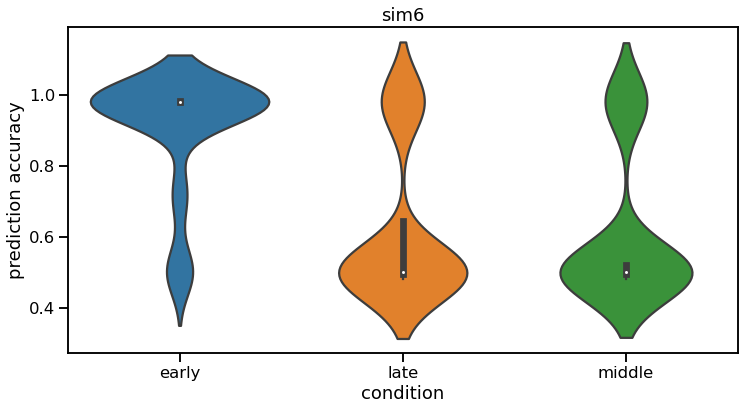

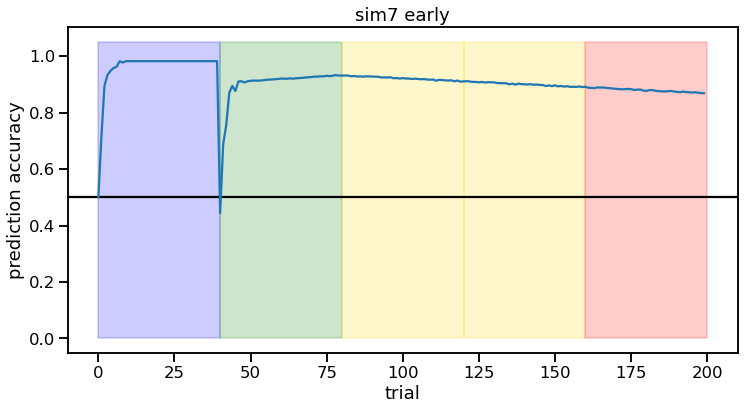

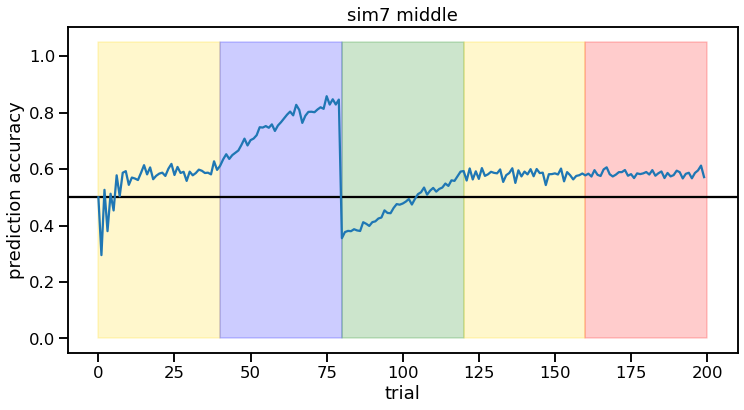

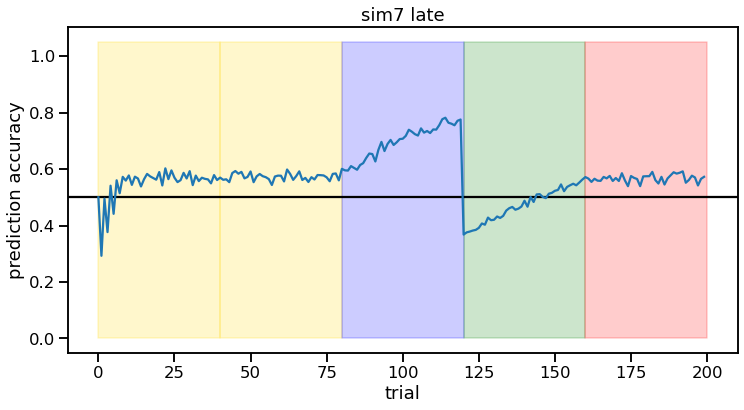

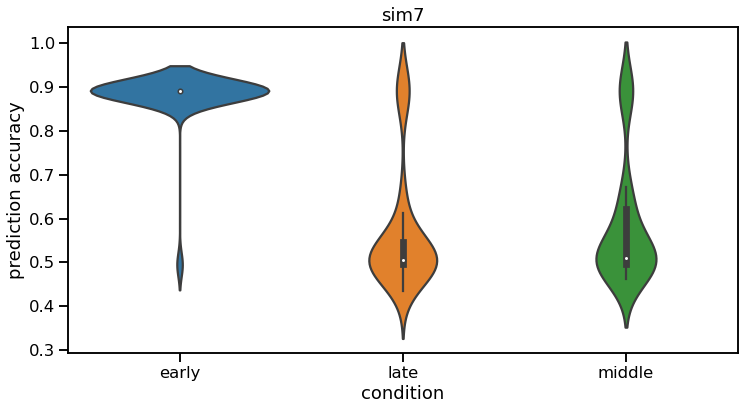

In [48]:
for gsname in all_sims:
    lineplot_modelEML(gsname)
    beeswarm_modelEML(gsname)